In [37]:
%reset -f

In [38]:
import pandas as pd
import csv
import pickle
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from pathlib import Path
import os

from stage1 import lasso_rolling_window, create_lagged_features, get_coefficient_dataframe, analyze_results
from stage2 import estimate_kappa

In [39]:
base_dir = Path(os.getenv("LASSO_OUTPUT_DIR", "output"))

In [40]:
features_path = Path("output") / "features.pkl"
response_path = Path("output") / "response.pkl"
return_path = Path("data") / "return84_20.csv"

with features_path.open("rb") as f:
    X = pickle.load(f)
    
with response_path.open("rb") as f:
    y = pickle.load(f)

if not return_path.exists():
    return_path = Path(r"C:\Users\jonat\Lasso_paper\Empirical\data\return84_20.csv")
    print("Using absolute path:", return_path)


Using absolute path: C:\Users\jonat\Lasso_paper\Empirical\data\return84_20.csv


In [41]:
y = np.log(y+1)

In [42]:
# # Cross-validated lambda
# res_cv = lasso_rolling_window(X, y, window_size=60, n_lags=3, lambda_mode="cv", cv_folds=5)
# # Fixed lambda
# res_fixed = lasso_rolling_window(X, y, window_size=60, n_lags=3,
#                                  lambda_mode="fixed", fixed_lambda=0.0005)

In [43]:

# # Access results
# lambdas = res_fixed['lambdas']
# coefficients = res_fixed['coefficients']

In [44]:
# df_coefs = get_coefficient_dataframe(results)
# analysis = analyze_results(results)

### We now estimated the 1st stage under the assumption that the agents PLM is estimated by LASSO.

The next step is now to use these forecasted returns to estimate the ALM.
The ALM in the 2nd stage is specified as: 

$$
r_{t+1} = \log(\varepsilon_{t+1}) 
+ \log(1 - \kappa e^{x'_t \beta}) 
- \log(1 - \kappa e^{x'_{t+1} \beta})
$$

$$
\kappa := \delta a^{-\gamma} \phi
$$

Here, $x'_t \beta$ and $x'_{t+1} \beta$ are the $t$ and $t+1$ return foreacsts of the agent from the 1st stage.

In [45]:
# # Create a DataFrame of predictions indexed by date
# stage2 = (
#     pd.DataFrame({
#         "predictions": results["predictions"]
#     }, index=pd.to_datetime(results["prediction_dates"]))
# )

# # Ensure returns index is datetime and join
# returns.index = pd.to_datetime(returns["DATE"])
# stage2 = returns.join(stage2, how='inner')

# # # Compute residuals (epsilon)
# stage2["epsilon"] = stage2["vwretd"] - stage2["predictions"]



Running rolling LASSO for lambda = 0.000001 ...


Rolling windows: 100%|██████████| 8407/8407 [12:30<00:00, 11.20it/s]



Running rolling LASSO for lambda = 0.000004 ...


Rolling windows: 100%|██████████| 8407/8407 [09:55<00:00, 14.12it/s]



Running rolling LASSO for lambda = 0.000013 ...


Rolling windows: 100%|██████████| 8407/8407 [07:07<00:00, 19.65it/s]



Running rolling LASSO for lambda = 0.000046 ...


Rolling windows: 100%|██████████| 8407/8407 [04:01<00:00, 34.75it/s]



Running rolling LASSO for lambda = 0.000167 ...


Rolling windows: 100%|██████████| 8407/8407 [01:53<00:00, 74.34it/s] 



Running rolling LASSO for lambda = 0.000599 ...


Rolling windows: 100%|██████████| 8407/8407 [00:40<00:00, 205.73it/s]



Running rolling LASSO for lambda = 0.002154 ...


Rolling windows: 100%|██████████| 8407/8407 [00:17<00:00, 487.75it/s]



Running rolling LASSO for lambda = 0.007743 ...


Rolling windows: 100%|██████████| 8407/8407 [00:12<00:00, 663.00it/s]



Running rolling LASSO for lambda = 0.027826 ...


Rolling windows: 100%|██████████| 8407/8407 [00:11<00:00, 708.63it/s]



Running rolling LASSO for lambda = 0.100000 ...


Rolling windows: 100%|██████████| 8407/8407 [00:12<00:00, 658.77it/s]



=== Kappa & Avg Active Predictors by Lambda ===
     lambda     kappa  avg_active_predictors
0  0.000001  0.912859              76.317355
1  0.000004  0.918292              45.556560
2  0.000013  0.935992              33.322588
3  0.000046  0.919175              29.743666
4  0.000167  0.906044              27.657666
5  0.000599  0.913079              23.156417
6  0.002154  0.920287              10.516355
7  0.007743  0.955526               0.639705
8  0.027826  0.981667               0.000595
9  0.100000  0.981667               0.000000


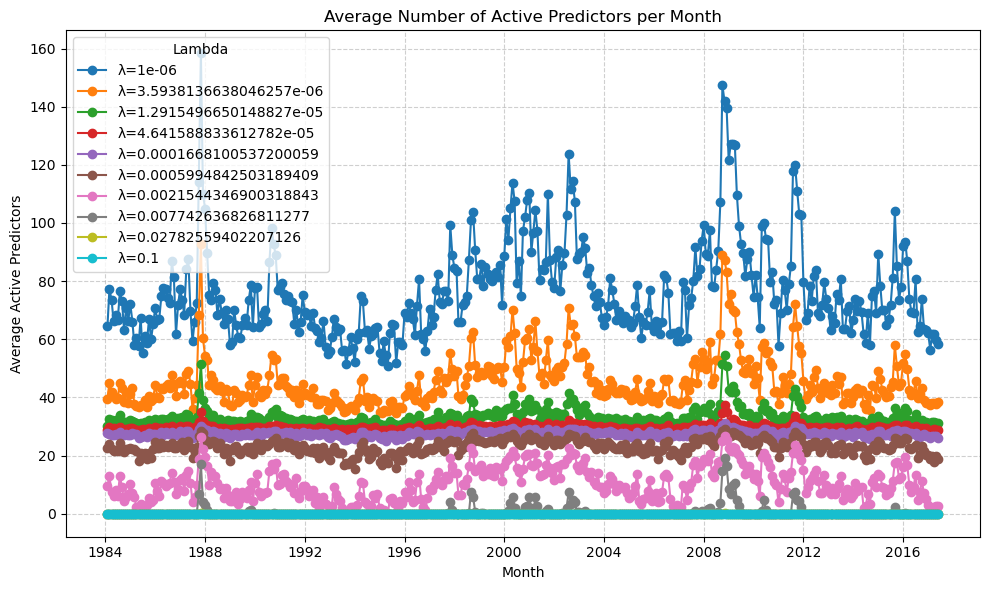

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stage1 import lasso_rolling_window
from stage2 import estimate_kappa

# --- Inputs (already created) ---
# X: np.ndarray of features
# y: np.ndarray of response variable (e.g., returns)
lambda_values = np.logspace(-6, -1, 10)

# lambda_values = [0.1, 0.01, 0.001, 0.0001, 0.0005, 0.00001]  # Example grid
results_summary = []
active_predictors_all = []
alm_returns_all = []  # NEW: store realized ALM returns

# === Helper: Compute ALM-implied realized returns ===
def compute_alm_returns(stage2_df, kappa):
    """
    Compute realized returns implied by the ALM:
    r_hat_{t+1} = log(eps_{t+1}) + log(1 - kappa * exp(pred_t)) - log(1 - kappa * exp(pred_{t+1}))
    """
    eps = np.maximum(stage2_df["epsilon"].values[1:], 1e-8)
    pred_t = stage2_df["predictions"].values[:-1]
    pred_t1 = stage2_df["predictions"].values[1:]

    valid = (1 - kappa * np.exp(pred_t) > 0) & (1 - kappa * np.exp(pred_t1) > 0)
    if not np.all(valid):
        # If invalid, truncate to valid portion only
        valid_idx = np.where(valid)[0]
        eps, pred_t, pred_t1 = eps[valid_idx], pred_t[valid_idx], pred_t1[valid_idx + 1]

    r_hat = np.log(eps) + np.log(1 - kappa * np.exp(pred_t)) - np.log(1 - kappa * np.exp(pred_t1))
    return pd.Series(r_hat, name="r_hat")

# === Main Loop ===
for lam in lambda_values:
    print(f"\nRunning rolling LASSO for lambda = {lam:.6f} ...")

    # Step 1: Rolling LASSO
    lasso_results = lasso_rolling_window(
        X=X,
        y=y,
        window_size=30,
        n_lags=3,
        lambda_mode="fixed",
        fixed_lambda=lam,
        verbose=False
    )

    # Step 2: Compute residuals
    preds = np.array(lasso_results["predictions"])
    y_valid = y[-len(preds):] if not isinstance(y, pd.Series) else y.iloc[-len(preds):]
    eps = y_valid.values - preds if isinstance(y_valid, pd.Series) else y_valid - preds

    stage2_input = pd.DataFrame({
        "vwretd": np.asarray(y_valid),
        "epsilon": eps,
        "predictions": preds
    })

    # Step 3: Estimate kappa
    try:
        kappa_est = estimate_kappa(stage2_input)
    except Exception as e:
        print(f"⚠️ Kappa estimation failed for λ={lam:.6f}: {e}")
        kappa_est = np.nan

    # Step 4: Active predictors per rolling window
    coefs = np.array(lasso_results["coefficients"])
    active_counts = np.count_nonzero(coefs, axis=1)

    if "window_end_dates" in lasso_results:
        dates = pd.to_datetime(lasso_results["window_end_dates"])
    else:
        dates = pd.RangeIndex(len(active_counts))

    active_df = pd.DataFrame({
        "date": dates,
        "active_predictors": active_counts,
        "lambda": lam
    })
    active_predictors_all.append(active_df)

    avg_active = np.mean(active_counts)

    # --- NEW: Compute ALM-implied realized returns ---
    if np.isfinite(kappa_est):
        alm_returns = compute_alm_returns(stage2_input, kappa_est)
        if isinstance(y_valid, pd.Series):
            alm_returns.index = y_valid.index[1:len(alm_returns)+1]
        alm_df = pd.DataFrame({
            "date": alm_returns.index,
            "r_hat": alm_returns.values,
            "lambda": lam
        })
        alm_returns_all.append(alm_df)

    results_summary.append({
        "lambda": lam,
        "kappa": kappa_est,
        "avg_active_predictors": avg_active
    })

# --- Summary Table ---
results_df = pd.DataFrame(results_summary)
print("\n=== Kappa & Avg Active Predictors by Lambda ===")
print(results_df)

# --- Combine Active Predictor Data ---
active_predictors_df = pd.concat(active_predictors_all, ignore_index=True)

# --- Combine ALM-implied returns ---
if alm_returns_all:
    alm_returns_long = pd.concat(alm_returns_all, ignore_index=True)
    # Pivot to wide: date index, columns = lambda values
    alm_returns_df = (
        alm_returns_long
        .pivot(index="date", columns="lambda", values="r_hat")
        .sort_index()
    )
else:
    alm_returns_df = None


# === Plot 1: Active Predictors (monthly) ===
if pd.api.types.is_datetime64_any_dtype(active_predictors_df["date"]):
    active_predictors_df["month"] = active_predictors_df["date"].dt.to_period("M").dt.to_timestamp()
    monthly_avg = (
        active_predictors_df
        .groupby(["lambda", "month"])["active_predictors"]
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(10, 6))
    for lam in lambda_values:
        subset = monthly_avg[monthly_avg["lambda"] == lam]
        plt.plot(subset["month"], subset["active_predictors"], marker="o", label=f"λ={lam}")
    plt.title("Average Number of Active Predictors per Month")
    plt.xlabel("Month")
    plt.ylabel("Average Active Predictors")
    plt.legend(title="Lambda")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ y has no datetime index — cannot create monthly time series plot.")


In [47]:
print(stage2_input["predictions"].describe())
print(np.exp(stage2_input["predictions"]).max())


count    8406.000000
mean        0.000348
std         0.002776
min        -0.065131
25%        -0.000399
50%         0.000604
75%         0.001488
max         0.027500
Name: predictions, dtype: float64
1.0278815968939499


In [ ]:
print(np.mean(alm_returns_all[0]["r_hat"]))

-11.910971445607316


In [50]:
print(alm_returns_df.mean())


lambda
0.01   -11.900140
0.10   -11.910971
dtype: float64
